## PurpleAir Data
Data are available via PurpleAir's API. You will need to use a gmail account and create an API key via [this dashboard](https://develop.purpleair.com/sign-in?redirectURL=%2Fdashboards%2Fkeys). You should create a "Read" key that has a status of "Enabled". It's a good idea to add a label, host restrictions restrict the use of the key to certain machines, you do not need to set these. 

TODO: insert screen shot image

Once you have generated your key, you can "read" the key value to use in making requests. First, run the cell below and enter the key you generated when prompted. 

If you do not have a Gmail account, or you don't want to set up an API, sample data shown here have been saved as part of the repository and can be used directly, just skip down to [insert section]

In [98]:
# imports
import datetime
import pytz
import getpass
import requests


import geopandas as gpd
import pandas as pd


In [2]:

api_key = getpass.getpass("Enter your API key: ")

Test your API key by running the code below. It should show the message "Key submit was successful" if your key is valid. 

In [ ]:
url = "https://api.purpleair.com/v1/keys"

headers = {
    "X-API-Key": api_key 
}

response = requests.get(url, headers=headers)

if response.status_code == 201:
    print('Key submit was successful')
    data = response.json()
    print(data)
else:
    print(f"Request failed with status code: {response.status_code}")

If the API key is valid, a bounding box can be used to search for sensors. The coordinates in the cell below represent the longitude and latitude of the northwest and southeast corners of a box that encloses the South Bronx. The API request returns the identifiers of sensors within that bounding box. 

In [ ]:
# corner latitude and longitudes in decimal degrees
nwlat = 40.9
nwlng = -73.933
selat = 40.80
selng = -73.78

url = 'https://api.purpleair.com/v1/sensors'

headers = {"X-API-Key": api_key}

params = {
    'fields':'name,latitude,longitude,position_rating,last_seen,date_created,private',
    'location_type':0,
    'nwlng':nwlng,
    'nwlat':nwlat,
    'selng':selng,
    'selat':selat

}

with requests.get(url, headers=headers, params=params) as response:

    if response.status_code == 200:
        print('Success')
        data = response.json()
        print(f'Request returned {len(data)} sensors')
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response)


Request failed with status code: 400
<Response [400]>


In [33]:
response.text

'{\n  "api_version" : "V1.0.14-0.0.58",\n  "time_stamp" : 1744726224,\n  "error" : "InvalidShowValueError",\n  "description" : "Show values should be integers separated by commas."\n}'

We can convert the sensor list to a dataframe and save it for future use. 

In [29]:
df = pd.DataFrame(data['data'], columns=data['fields'])
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"
)

print(gdf.shape)
gdf.to_parquet('./SouthBronxSensors.parquet', engine='pyarrow', compression='snappy')


(10, 9)


If the data didn't download properly, or you cannot set up an API key, you can uncomment the code below will load the locally saved version of the file. 

In [65]:
gdf = gpd.read_parquet('./data/SouthBronxPurpleAirSensors.parquet')
print(gdf.shape)
gdf.head()


(10, 9)


,sensor_index,date_created,last_seen,private,name,position_rating,latitude,longitude,geometry
0,90249,1605560768,1744725955,0,FreshAir-O4,3,40.861225,-73.890160,POINT (-73.89016 40.86122)
1,90269,1605561082,1744725911,0,FA-O4,5,40.858074,-73.888980,POINT (-73.88898 40.85807)
2,90283,1605561111,1744716474,0,SIS-roof,5,40.815360,-73.888374,POINT (-73.88837 40.81536)
3,90389,1605561629,1744725226,0,FA-AHo,5,40.830220,-73.922340,POINT (-73.92234 40.83022)
4,91423,1605893083,1744726007,0,FA-O2b,5,40.861134,-73.891556,POINT (-73.89156 40.86113)


In [31]:
## check if any of the sensors are private
print(len(gdf[gdf['private'] == 1]))
# map to show the sensors
#gdf.explore()


0


With several sensors available, data can be pulled from the API. First, we can look at the sensors date created and last date collected to see if they are likely to have data in the time period we are interested in. Pandas, a library for working with datatables, has a helper method to convert the timestamp in the data from seconds to a human-readable date and time. 

In [35]:
# date_created is when the sensor was set up in the database, last_seen
# is the date & time for the last sensor recording
print('Date Created:')
print(pd.to_datetime(gdf.date_created, unit='s'))
print('\nDate Last Seen:')
print(pd.to_datetime(gdf.last_seen, unit='s'))

Date Created:
0   2020-11-16 21:06:08
1   2020-11-16 21:11:22
2   2020-11-16 21:11:51
3   2020-11-16 21:20:29
4   2020-11-20 17:24:43
5   2020-11-23 18:54:41
6   2020-11-24 17:25:14
7   2020-11-24 17:25:22
8   2022-11-29 19:05:50
9   2023-12-27 16:41:38
Name: date_created, dtype: datetime64[ns]

Date Last Seen:
0   2025-04-15 14:05:55
1   2025-04-15 14:05:11
2   2025-04-15 11:27:54
3   2025-04-15 13:53:46
4   2025-04-15 14:06:47
5   2025-04-15 14:05:23
6   2025-04-15 14:05:16
7   2025-04-15 14:05:20
8   2025-04-15 14:05:52
9   2025-04-15 14:06:52
Name: last_seen, dtype: datetime64[ns]


From this, it can be seen that all of the sensors were created before the fires, and all have collected data recently. Next, the code below will retrieve data from one of the sensors for the date of the event. 

To retrieve data, the sensor ID is used to construct a new request, including the columns we want to include and the date/time range from which to get data. 

In [36]:
# TODO: turn comments into table above
fields = [
    'pm2.5_alt',        #Estimated mass concentration PM2.5 (µg/m³).
    'pm2.5_atm',        #Estimated mass concentration PM2.5 (µg/m³) (raw value).
    'humidity',         #Relative humidity inside of the sensor housing (%). This matches the "Raw Humidity" map layer and on average is 4% lower than ambient conditions.
    'temperature',      #Temperature inside of the sensor housing (F). This matches the "Raw Temperature" map layer and on average is 8°F higher than ambient conditions.
    'pressure',         #Current pressure in Millibars.
]

In [99]:
# start and end datetime stamps
# stored on the server in UTC, so we
# can use a timezone to get that info
nytz = pytz.timezone('America/New_York')

start_date = datetime.datetime(2024,11,7,0,0,0,tzinfo=nytz).timestamp()
end_date = datetime.datetime(2024,11,10,23,59,59,tzinfo=nytz).timestamp()


In [100]:


sensor_ids = gdf.sensor_index.values
# get the first id for testing
id = sensor_ids[1]

# dictionary to hold returned sensor data
sensor_data = {}
# construct a request
# update the url, it is the API sensor url with :sensor after the end of the base URL
url = f"https://api.purpleair.com/v1/sensors/{id}/history" 

# new parameters
params = {
    # 'sensor_index':id, # encoded in URL
    'fields':",".join(fields),
    'start_timestamp':start_date,
    'end_timestamp':end_date,

}

with requests.get(url=url, headers=headers, params=params) as response:

    if response.status_code == 200 or response.status_code == 201:
        print('Success')
        sensor_data = response.json()
        print(len(sensor_data))


    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

Success
9


In [103]:
# function to create dataframe from retrieved data
def dataframe_from_api_data(records:list, column_names:list, timestamp_column:str=None)->pd.DataFrame:
    '''create a pandas dataframe using the supplied list of records and list of column names,
    set the index to be the datetime stamp, and sort the dataframe'''
    new_df = pd.DataFrame(
        data=records,
        columns=column_names
    )
    # if there is a timestamp column, convert it, set it as an index,
    # and then sort the dataframe
    if timestamp_column:
        tmp_col = 'tmp_datetime'
        new_df[tmp_col] =  pd.to_datetime(new_df[timestamp_column], unit='s')
        new_df.set_index(tmp_col, inplace=True)
        return new_df.sort_index()
    return new_df
    

In [104]:
df_sensor = dataframe_from_api_data(
    records = sensor_data.get('data'), 
    column_names = sensor_data.get('fields'),
    timestamp_column='time_stamp'
)
print(df_sensor.shape)
df_sensor.head()
# sample_data = history_data.get('data')
# type(sample_data)

(576, 6)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm
tmp_datetime,,,,,,
2024-11-07 04:50:00,1730955000,100.0,78.4,675.670,5.8,9.734
2024-11-07 05:00:00,1730955600,100.0,78.0,675.678,5.7,9.562
2024-11-07 05:10:00,1730956200,100.0,78.0,675.702,5.5,8.864
2024-11-07 05:20:00,1730956800,100.0,77.8,675.716,5.5,8.999
2024-11-07 05:30:00,1730957400,100.0,77.0,675.732,5.5,9.073


In [105]:
# # convert the time stamp to a date/time, and set it as the index (and sort it)
# df_sensor['collection_datetime'] =  pd.to_datetime(df_sensor['time_stamp'], unit='s')
# df_sensor.set_index('collection_datetime', inplace=True)
# df_sensor = df_sensor.sort_index()
# df_sensor.head()

<Axes: xlabel='tmp_datetime'>

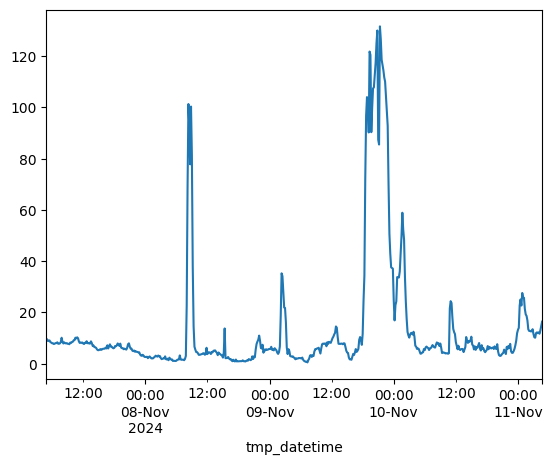

In [106]:
df_sensor['pm2.5_atm'].plot()


<Axes: >

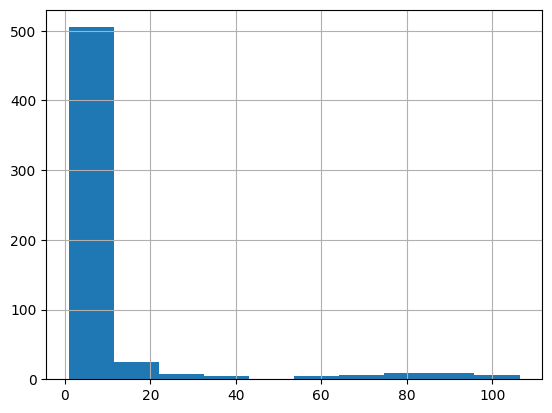

In [107]:

df_sensor['pm2.5_alt'].hist()



<Axes: xlabel='tmp_datetime'>

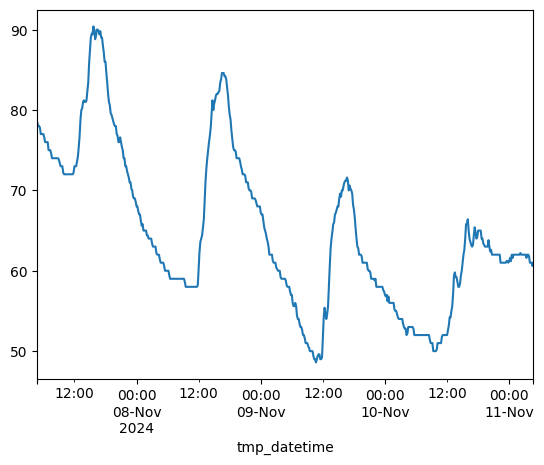

In [108]:
df_sensor['temperature'].plot()

<Axes: xlabel='tmp_datetime'>

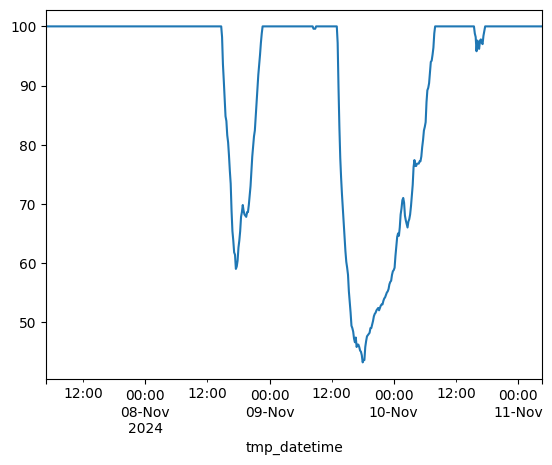

In [109]:
df_sensor['humidity'].plot()

<Axes: xlabel='tmp_datetime'>

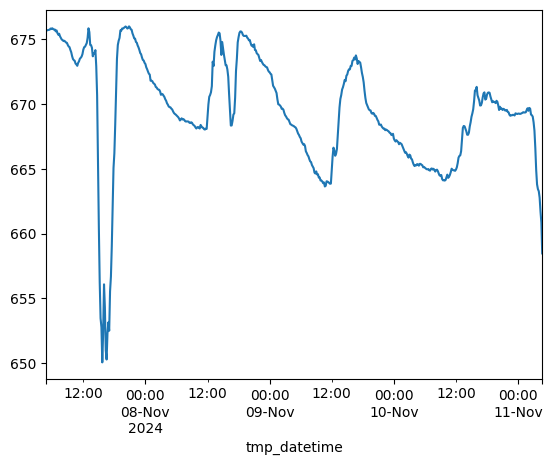

In [110]:
df_sensor['pressure'].plot()

In [111]:
# write out the data so we don't have to fetch it again
out_file = f'PurpleAir_sensor_{id}_2024_11_07_to_11_10.parquet'
df_sensor.to_parquet(f'./data/{out_file}')

In [82]:
#start_date = datetime.datetime(2024,11,7).timestamp()
#end_date = datetime.datetime(2024,11,10).timestamp()
datetime.datetime(2024,11,10,23,59,59).timestamp()


1731301199.0